# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

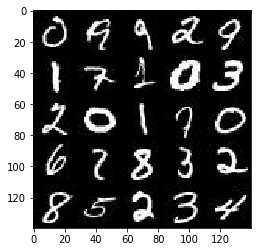

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

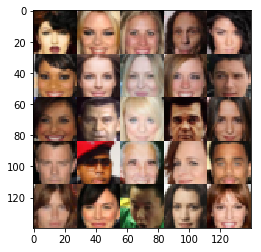

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learn_rate = tf.placeholder(tf.float32, name='learn_rate')
    
    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [21]:
weights_initializer = tf.contrib.layers.xavier_initializer()
keep_prob = 0.9

def leaky_relu(x, alpha=0.1, name='leaky_relu'):
    return tf.maximum(x, alpha * x, name=name)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input Layer 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=weights_initializer)
        do1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        #relu1 = leaky_relu(x1)
        relu1 = leaky_relu(do1)
        # 14x14x64
        
        # 2nd conv layer
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=weights_initializer)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        do2 = tf.nn.dropout(bn2, keep_prob=keep_prob)
        #relu2 = leaky_relu(bn2)
        relu2 = leaky_relu(do2)
        # 7x7x128
        
        #x3 = tf.layers.conv2d(relu2, 256, 4, stride=1, padding='valid')
        
        # Output layer
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [37]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
    
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        rs1 = tf.reshape(x1, (-1, 7, 7, 256))
        bn1 = tf.layers.batch_normalization(rs1, training=is_train)
        do1 = tf.nn.dropout(bn1, keep_prob=keep_prob)
        #relu1 = leaky_relu(bn1)
        relu1 = leaky_relu(do1)
        
        # 2nd conv layer
        x2 = tf.layers.conv2d_transpose(relu1, 128, 5, strides=2, padding='SAME', kernel_initializer=weights_initializer)
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        do2 = tf.nn.dropout(bn2, keep_prob=keep_prob)
        #relu2 = leaky_relu(bn2)
        relu2 = leaky_relu(do2)
        
        # 3rd conv layer
        #x3 = tf.layers.conv2d_transpose(relu2, out_channel_dim, 5, strides=2, padding='SAME')
        #bn3 = tf.layers.batch_normalization(x3, training=is_train)
        #relu3 = tf.maximum(alpha * bn3, bn3)
        
        # output layer
        logits = tf.layers.conv2d_transpose(relu2, out_channel_dim, 5, strides=2, padding='SAME', kernel_initializer=weights_initializer)
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [38]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [39]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [40]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [47]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #print(data_shape)
    #print(data_image_mode)
    #print(epoch_count)
    #tf.reset_default_graph()
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    #saver = tf.train.Saver()
    #sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    #samples, losses = [], []
    steps = 0
            
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            #print(epoch_i)
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # TODO: Train Model
                batch_images = batch_images * 2
                #print(batch_images)
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z, learn_rate:learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, learn_rate:learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8758... Generator Loss: 1.0992
Epoch 1/2... Discriminator Loss: 0.9156... Generator Loss: 1.0780
Epoch 1/2... Discriminator Loss: 0.8776... Generator Loss: 1.2096
Epoch 1/2... Discriminator Loss: 0.8725... Generator Loss: 1.5157
Epoch 1/2... Discriminator Loss: 0.8046... Generator Loss: 1.4999
Epoch 1/2... Discriminator Loss: 0.5195... Generator Loss: 2.3370
Epoch 1/2... Discriminator Loss: 0.7463... Generator Loss: 1.9436
Epoch 1/2... Discriminator Loss: 1.0158... Generator Loss: 1.3576
Epoch 1/2... Discriminator Loss: 1.0084... Generator Loss: 1.0720
Epoch 1/2... Discriminator Loss: 1.1540... Generator Loss: 0.9836


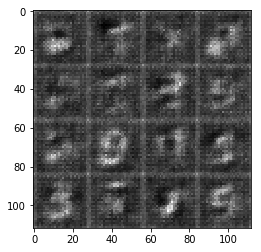

Epoch 1/2... Discriminator Loss: 1.1066... Generator Loss: 0.9965
Epoch 1/2... Discriminator Loss: 0.9960... Generator Loss: 1.0512
Epoch 1/2... Discriminator Loss: 1.0541... Generator Loss: 1.0783
Epoch 1/2... Discriminator Loss: 1.1225... Generator Loss: 0.9026
Epoch 1/2... Discriminator Loss: 1.1175... Generator Loss: 0.8959
Epoch 1/2... Discriminator Loss: 1.0574... Generator Loss: 1.0107
Epoch 1/2... Discriminator Loss: 1.0108... Generator Loss: 1.3037
Epoch 1/2... Discriminator Loss: 1.1753... Generator Loss: 1.4124
Epoch 1/2... Discriminator Loss: 0.9834... Generator Loss: 1.0418
Epoch 1/2... Discriminator Loss: 1.0198... Generator Loss: 1.6137


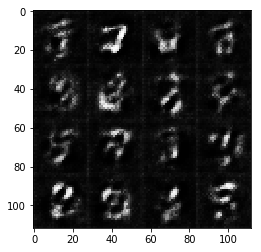

Epoch 1/2... Discriminator Loss: 1.0254... Generator Loss: 1.4921
Epoch 1/2... Discriminator Loss: 1.0435... Generator Loss: 1.4317
Epoch 1/2... Discriminator Loss: 1.0629... Generator Loss: 1.1960
Epoch 1/2... Discriminator Loss: 1.0140... Generator Loss: 1.2417
Epoch 1/2... Discriminator Loss: 1.1398... Generator Loss: 0.8488
Epoch 1/2... Discriminator Loss: 1.0463... Generator Loss: 0.9115
Epoch 1/2... Discriminator Loss: 1.0437... Generator Loss: 1.3942
Epoch 1/2... Discriminator Loss: 0.9605... Generator Loss: 1.2538
Epoch 1/2... Discriminator Loss: 0.9590... Generator Loss: 1.0798
Epoch 1/2... Discriminator Loss: 0.9594... Generator Loss: 1.3209


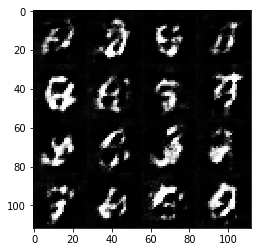

Epoch 1/2... Discriminator Loss: 1.1134... Generator Loss: 0.8951
Epoch 1/2... Discriminator Loss: 1.0218... Generator Loss: 1.2178
Epoch 1/2... Discriminator Loss: 0.9833... Generator Loss: 1.6921
Epoch 1/2... Discriminator Loss: 1.0063... Generator Loss: 1.0724
Epoch 1/2... Discriminator Loss: 0.9340... Generator Loss: 1.5807
Epoch 1/2... Discriminator Loss: 0.9151... Generator Loss: 1.5591
Epoch 1/2... Discriminator Loss: 1.0007... Generator Loss: 1.0795
Epoch 1/2... Discriminator Loss: 0.8372... Generator Loss: 1.5986
Epoch 1/2... Discriminator Loss: 0.9402... Generator Loss: 1.2307
Epoch 1/2... Discriminator Loss: 0.8914... Generator Loss: 1.3511


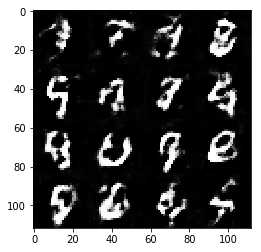

Epoch 1/2... Discriminator Loss: 0.9171... Generator Loss: 1.0124
Epoch 1/2... Discriminator Loss: 0.8999... Generator Loss: 1.1270
Epoch 1/2... Discriminator Loss: 0.9604... Generator Loss: 1.6245
Epoch 1/2... Discriminator Loss: 0.9844... Generator Loss: 0.9633
Epoch 1/2... Discriminator Loss: 0.8851... Generator Loss: 1.7307
Epoch 1/2... Discriminator Loss: 0.9237... Generator Loss: 1.1445
Epoch 1/2... Discriminator Loss: 0.8855... Generator Loss: 1.5721
Epoch 1/2... Discriminator Loss: 0.8937... Generator Loss: 1.4008
Epoch 1/2... Discriminator Loss: 0.8774... Generator Loss: 1.1647
Epoch 1/2... Discriminator Loss: 0.9377... Generator Loss: 1.1814


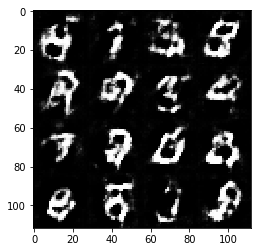

Epoch 1/2... Discriminator Loss: 0.9897... Generator Loss: 1.1509
Epoch 1/2... Discriminator Loss: 0.8875... Generator Loss: 1.5356
Epoch 1/2... Discriminator Loss: 0.8545... Generator Loss: 1.2872
Epoch 1/2... Discriminator Loss: 0.8740... Generator Loss: 1.5648
Epoch 1/2... Discriminator Loss: 0.8786... Generator Loss: 1.3366
Epoch 1/2... Discriminator Loss: 0.9971... Generator Loss: 1.3946
Epoch 1/2... Discriminator Loss: 0.8598... Generator Loss: 1.6575
Epoch 1/2... Discriminator Loss: 0.9380... Generator Loss: 1.3587
Epoch 1/2... Discriminator Loss: 0.8816... Generator Loss: 1.1502
Epoch 1/2... Discriminator Loss: 0.8777... Generator Loss: 1.3921


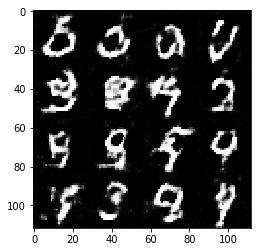

Epoch 1/2... Discriminator Loss: 0.8688... Generator Loss: 1.2100
Epoch 1/2... Discriminator Loss: 0.8222... Generator Loss: 1.4116
Epoch 1/2... Discriminator Loss: 0.8364... Generator Loss: 1.9772
Epoch 1/2... Discriminator Loss: 0.9133... Generator Loss: 1.1487
Epoch 1/2... Discriminator Loss: 1.0354... Generator Loss: 0.8878
Epoch 1/2... Discriminator Loss: 1.1186... Generator Loss: 2.0848
Epoch 1/2... Discriminator Loss: 0.9203... Generator Loss: 1.5693
Epoch 1/2... Discriminator Loss: 1.0530... Generator Loss: 1.0994
Epoch 1/2... Discriminator Loss: 0.9834... Generator Loss: 0.9719
Epoch 1/2... Discriminator Loss: 0.9654... Generator Loss: 1.5215


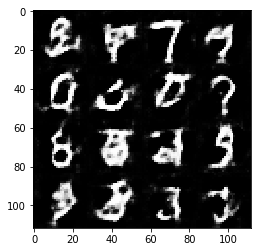

Epoch 1/2... Discriminator Loss: 0.9391... Generator Loss: 1.8494
Epoch 1/2... Discriminator Loss: 1.0470... Generator Loss: 1.0140
Epoch 1/2... Discriminator Loss: 1.0706... Generator Loss: 1.6389
Epoch 1/2... Discriminator Loss: 1.1432... Generator Loss: 1.7637
Epoch 1/2... Discriminator Loss: 0.9958... Generator Loss: 1.0118
Epoch 1/2... Discriminator Loss: 1.0921... Generator Loss: 1.2154
Epoch 1/2... Discriminator Loss: 1.0230... Generator Loss: 1.7215
Epoch 1/2... Discriminator Loss: 1.0003... Generator Loss: 1.1064
Epoch 1/2... Discriminator Loss: 0.8623... Generator Loss: 1.4274
Epoch 1/2... Discriminator Loss: 1.0778... Generator Loss: 1.5680


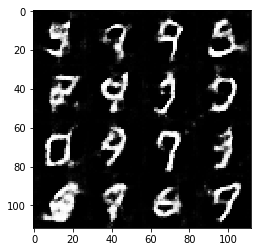

Epoch 1/2... Discriminator Loss: 0.9906... Generator Loss: 1.2751
Epoch 1/2... Discriminator Loss: 0.9931... Generator Loss: 1.5622
Epoch 1/2... Discriminator Loss: 1.0280... Generator Loss: 1.5730
Epoch 1/2... Discriminator Loss: 0.9540... Generator Loss: 1.8385
Epoch 1/2... Discriminator Loss: 0.9931... Generator Loss: 0.9638
Epoch 1/2... Discriminator Loss: 0.8897... Generator Loss: 1.2982
Epoch 1/2... Discriminator Loss: 1.0286... Generator Loss: 1.1823
Epoch 1/2... Discriminator Loss: 1.0311... Generator Loss: 1.1920
Epoch 1/2... Discriminator Loss: 1.0645... Generator Loss: 1.1627
Epoch 1/2... Discriminator Loss: 1.1310... Generator Loss: 0.8033


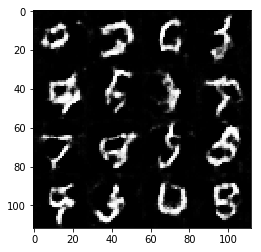

Epoch 1/2... Discriminator Loss: 1.0444... Generator Loss: 1.0690
Epoch 1/2... Discriminator Loss: 0.8631... Generator Loss: 1.4673
Epoch 1/2... Discriminator Loss: 1.0586... Generator Loss: 1.9196
Epoch 2/2... Discriminator Loss: 0.9179... Generator Loss: 1.1700
Epoch 2/2... Discriminator Loss: 1.0742... Generator Loss: 1.0819
Epoch 2/2... Discriminator Loss: 1.0228... Generator Loss: 1.0604
Epoch 2/2... Discriminator Loss: 1.0372... Generator Loss: 1.1979
Epoch 2/2... Discriminator Loss: 1.0195... Generator Loss: 1.3397
Epoch 2/2... Discriminator Loss: 0.9776... Generator Loss: 1.2344
Epoch 2/2... Discriminator Loss: 0.9368... Generator Loss: 1.1962


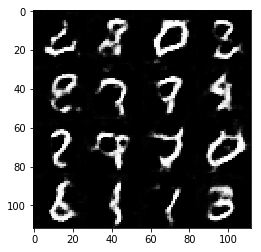

Epoch 2/2... Discriminator Loss: 0.9705... Generator Loss: 1.1875
Epoch 2/2... Discriminator Loss: 1.0342... Generator Loss: 1.3446
Epoch 2/2... Discriminator Loss: 1.0622... Generator Loss: 0.9200
Epoch 2/2... Discriminator Loss: 1.0512... Generator Loss: 1.4100
Epoch 2/2... Discriminator Loss: 1.0061... Generator Loss: 1.0211
Epoch 2/2... Discriminator Loss: 1.1039... Generator Loss: 0.7875
Epoch 2/2... Discriminator Loss: 0.9853... Generator Loss: 1.1032
Epoch 2/2... Discriminator Loss: 1.0106... Generator Loss: 1.3245
Epoch 2/2... Discriminator Loss: 0.9761... Generator Loss: 1.0174
Epoch 2/2... Discriminator Loss: 0.9805... Generator Loss: 1.1987


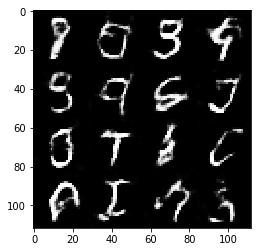

Epoch 2/2... Discriminator Loss: 0.9018... Generator Loss: 1.5857
Epoch 2/2... Discriminator Loss: 0.9867... Generator Loss: 1.3737
Epoch 2/2... Discriminator Loss: 1.0592... Generator Loss: 0.9240
Epoch 2/2... Discriminator Loss: 0.9729... Generator Loss: 1.0481
Epoch 2/2... Discriminator Loss: 1.0333... Generator Loss: 0.9125
Epoch 2/2... Discriminator Loss: 0.9715... Generator Loss: 0.9709
Epoch 2/2... Discriminator Loss: 0.9988... Generator Loss: 1.4233
Epoch 2/2... Discriminator Loss: 1.0691... Generator Loss: 1.2412
Epoch 2/2... Discriminator Loss: 1.0314... Generator Loss: 1.0197
Epoch 2/2... Discriminator Loss: 1.0079... Generator Loss: 1.4501


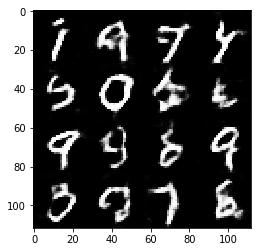

Epoch 2/2... Discriminator Loss: 1.1196... Generator Loss: 1.7504
Epoch 2/2... Discriminator Loss: 1.0440... Generator Loss: 1.1292
Epoch 2/2... Discriminator Loss: 1.0559... Generator Loss: 0.9780
Epoch 2/2... Discriminator Loss: 0.9927... Generator Loss: 1.4677
Epoch 2/2... Discriminator Loss: 1.0509... Generator Loss: 1.2014
Epoch 2/2... Discriminator Loss: 1.1709... Generator Loss: 1.1902
Epoch 2/2... Discriminator Loss: 1.0218... Generator Loss: 1.2574
Epoch 2/2... Discriminator Loss: 0.9059... Generator Loss: 1.1560
Epoch 2/2... Discriminator Loss: 0.9846... Generator Loss: 1.8226
Epoch 2/2... Discriminator Loss: 0.9844... Generator Loss: 1.2034


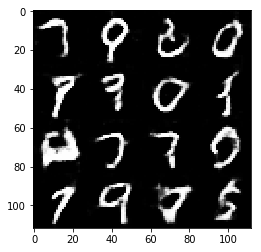

Epoch 2/2... Discriminator Loss: 1.0494... Generator Loss: 1.5416
Epoch 2/2... Discriminator Loss: 0.9700... Generator Loss: 1.3481
Epoch 2/2... Discriminator Loss: 1.0126... Generator Loss: 1.4364
Epoch 2/2... Discriminator Loss: 1.1606... Generator Loss: 0.9582
Epoch 2/2... Discriminator Loss: 1.0954... Generator Loss: 1.0063
Epoch 2/2... Discriminator Loss: 0.9898... Generator Loss: 1.5008
Epoch 2/2... Discriminator Loss: 0.9803... Generator Loss: 1.4290
Epoch 2/2... Discriminator Loss: 1.0175... Generator Loss: 1.3897
Epoch 2/2... Discriminator Loss: 1.0339... Generator Loss: 0.9866
Epoch 2/2... Discriminator Loss: 0.9200... Generator Loss: 1.5201


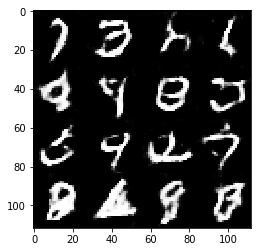

Epoch 2/2... Discriminator Loss: 0.9604... Generator Loss: 1.0641
Epoch 2/2... Discriminator Loss: 1.0002... Generator Loss: 1.6925
Epoch 2/2... Discriminator Loss: 0.9763... Generator Loss: 1.3852
Epoch 2/2... Discriminator Loss: 1.0482... Generator Loss: 1.6185
Epoch 2/2... Discriminator Loss: 1.0761... Generator Loss: 1.4122
Epoch 2/2... Discriminator Loss: 1.1836... Generator Loss: 1.5497
Epoch 2/2... Discriminator Loss: 0.9924... Generator Loss: 1.3535
Epoch 2/2... Discriminator Loss: 1.1680... Generator Loss: 0.8687
Epoch 2/2... Discriminator Loss: 1.0286... Generator Loss: 1.4309
Epoch 2/2... Discriminator Loss: 1.0664... Generator Loss: 0.8250


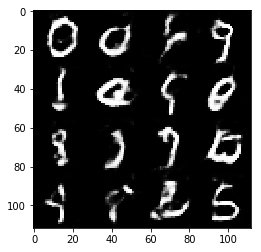

Epoch 2/2... Discriminator Loss: 1.1528... Generator Loss: 0.7851
Epoch 2/2... Discriminator Loss: 1.1224... Generator Loss: 0.8819
Epoch 2/2... Discriminator Loss: 1.0667... Generator Loss: 1.0017
Epoch 2/2... Discriminator Loss: 0.9387... Generator Loss: 1.3945
Epoch 2/2... Discriminator Loss: 1.0770... Generator Loss: 0.8409
Epoch 2/2... Discriminator Loss: 0.9785... Generator Loss: 1.2825
Epoch 2/2... Discriminator Loss: 1.1291... Generator Loss: 1.8115
Epoch 2/2... Discriminator Loss: 0.9492... Generator Loss: 1.3284
Epoch 2/2... Discriminator Loss: 1.1225... Generator Loss: 1.8205
Epoch 2/2... Discriminator Loss: 1.1859... Generator Loss: 0.9699


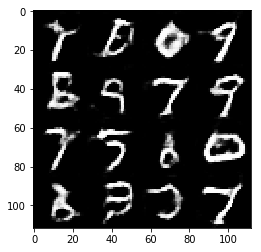

Epoch 2/2... Discriminator Loss: 1.0979... Generator Loss: 1.7669
Epoch 2/2... Discriminator Loss: 0.9857... Generator Loss: 1.5544
Epoch 2/2... Discriminator Loss: 0.9030... Generator Loss: 1.5515
Epoch 2/2... Discriminator Loss: 0.9774... Generator Loss: 1.1105
Epoch 2/2... Discriminator Loss: 1.0236... Generator Loss: 1.5424
Epoch 2/2... Discriminator Loss: 0.9751... Generator Loss: 1.3466
Epoch 2/2... Discriminator Loss: 0.8973... Generator Loss: 1.6678
Epoch 2/2... Discriminator Loss: 1.1004... Generator Loss: 1.9576
Epoch 2/2... Discriminator Loss: 1.0688... Generator Loss: 1.3181
Epoch 2/2... Discriminator Loss: 0.9181... Generator Loss: 1.2898


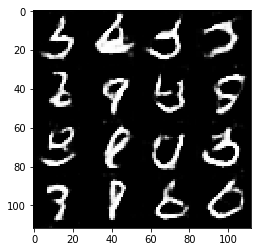

Epoch 2/2... Discriminator Loss: 0.9763... Generator Loss: 1.0344
Epoch 2/2... Discriminator Loss: 1.0077... Generator Loss: 0.9692
Epoch 2/2... Discriminator Loss: 0.9395... Generator Loss: 1.2609
Epoch 2/2... Discriminator Loss: 1.2185... Generator Loss: 0.6923
Epoch 2/2... Discriminator Loss: 0.8889... Generator Loss: 1.3147
Epoch 2/2... Discriminator Loss: 0.9773... Generator Loss: 1.2790
Epoch 2/2... Discriminator Loss: 1.0209... Generator Loss: 1.2874
Epoch 2/2... Discriminator Loss: 0.9595... Generator Loss: 1.1286
Epoch 2/2... Discriminator Loss: 0.9665... Generator Loss: 1.7824
Epoch 2/2... Discriminator Loss: 0.9296... Generator Loss: 1.3820


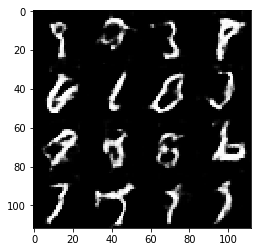

Epoch 2/2... Discriminator Loss: 1.0443... Generator Loss: 1.8371
Epoch 2/2... Discriminator Loss: 0.9015... Generator Loss: 1.1818
Epoch 2/2... Discriminator Loss: 0.9820... Generator Loss: 0.8849
Epoch 2/2... Discriminator Loss: 0.8814... Generator Loss: 1.6222
Epoch 2/2... Discriminator Loss: 1.4221... Generator Loss: 2.1546
Epoch 2/2... Discriminator Loss: 0.9774... Generator Loss: 1.6983
Epoch 2/2... Discriminator Loss: 1.0273... Generator Loss: 0.9227


In [48]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.0457... Generator Loss: 1.1652
Epoch 1/1... Discriminator Loss: 0.7467... Generator Loss: 1.8124
Epoch 1/1... Discriminator Loss: 0.7356... Generator Loss: 1.6474
Epoch 1/1... Discriminator Loss: 0.6180... Generator Loss: 2.1590
Epoch 1/1... Discriminator Loss: 0.7627... Generator Loss: 1.8276
Epoch 1/1... Discriminator Loss: 0.6346... Generator Loss: 2.4681
Epoch 1/1... Discriminator Loss: 0.7053... Generator Loss: 2.5354
Epoch 1/1... Discriminator Loss: 0.8086... Generator Loss: 1.6176
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 0.9830


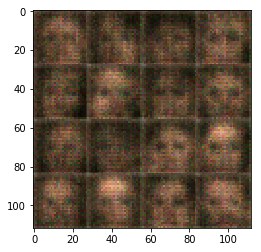

Epoch 1/1... Discriminator Loss: 0.8066... Generator Loss: 1.4985
Epoch 1/1... Discriminator Loss: 0.7863... Generator Loss: 1.6377
Epoch 1/1... Discriminator Loss: 0.6002... Generator Loss: 1.9063
Epoch 1/1... Discriminator Loss: 0.7883... Generator Loss: 1.6770
Epoch 1/1... Discriminator Loss: 0.7414... Generator Loss: 1.7246
Epoch 1/1... Discriminator Loss: 0.6579... Generator Loss: 2.2304
Epoch 1/1... Discriminator Loss: 0.7112... Generator Loss: 2.0382
Epoch 1/1... Discriminator Loss: 0.7397... Generator Loss: 2.3518
Epoch 1/1... Discriminator Loss: 0.7510... Generator Loss: 2.8816
Epoch 1/1... Discriminator Loss: 0.6594... Generator Loss: 2.2187


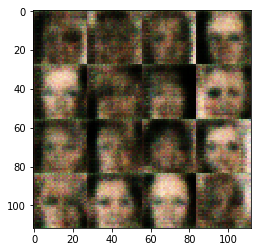

Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 3.4972
Epoch 1/1... Discriminator Loss: 0.6094... Generator Loss: 2.0482
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 0.8044... Generator Loss: 1.2662
Epoch 1/1... Discriminator Loss: 0.6625... Generator Loss: 2.0151
Epoch 1/1... Discriminator Loss: 0.7819... Generator Loss: 1.3981
Epoch 1/1... Discriminator Loss: 0.7165... Generator Loss: 1.6471
Epoch 1/1... Discriminator Loss: 0.6703... Generator Loss: 2.0556
Epoch 1/1... Discriminator Loss: 0.8826... Generator Loss: 1.0952
Epoch 1/1... Discriminator Loss: 1.0104... Generator Loss: 3.2664


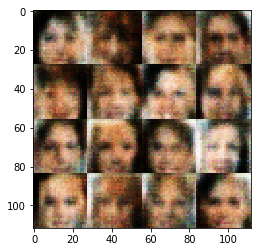

Epoch 1/1... Discriminator Loss: 0.7035... Generator Loss: 1.9283
Epoch 1/1... Discriminator Loss: 0.7806... Generator Loss: 2.2755
Epoch 1/1... Discriminator Loss: 0.8741... Generator Loss: 1.0581
Epoch 1/1... Discriminator Loss: 0.7037... Generator Loss: 1.7648
Epoch 1/1... Discriminator Loss: 0.8692... Generator Loss: 1.2320
Epoch 1/1... Discriminator Loss: 0.6525... Generator Loss: 2.1682
Epoch 1/1... Discriminator Loss: 0.8212... Generator Loss: 1.1109
Epoch 1/1... Discriminator Loss: 0.7715... Generator Loss: 1.4018
Epoch 1/1... Discriminator Loss: 0.6586... Generator Loss: 2.1770
Epoch 1/1... Discriminator Loss: 0.8721... Generator Loss: 0.9983


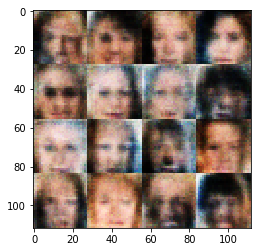

Epoch 1/1... Discriminator Loss: 0.7241... Generator Loss: 1.4909
Epoch 1/1... Discriminator Loss: 0.7187... Generator Loss: 1.7407
Epoch 1/1... Discriminator Loss: 0.9598... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 0.7242... Generator Loss: 1.4778
Epoch 1/1... Discriminator Loss: 0.8635... Generator Loss: 1.1782
Epoch 1/1... Discriminator Loss: 0.9921... Generator Loss: 0.8925
Epoch 1/1... Discriminator Loss: 0.7320... Generator Loss: 1.4661
Epoch 1/1... Discriminator Loss: 0.8536... Generator Loss: 1.3996
Epoch 1/1... Discriminator Loss: 0.7980... Generator Loss: 2.0116
Epoch 1/1... Discriminator Loss: 0.8601... Generator Loss: 1.2767


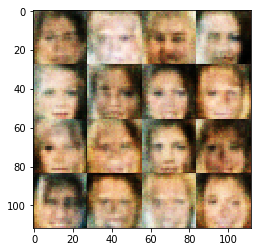

Epoch 1/1... Discriminator Loss: 0.6911... Generator Loss: 2.2977
Epoch 1/1... Discriminator Loss: 0.6615... Generator Loss: 1.7543
Epoch 1/1... Discriminator Loss: 0.8174... Generator Loss: 1.6741
Epoch 1/1... Discriminator Loss: 0.8527... Generator Loss: 1.9569
Epoch 1/1... Discriminator Loss: 0.9652... Generator Loss: 1.0355
Epoch 1/1... Discriminator Loss: 0.7465... Generator Loss: 1.3668
Epoch 1/1... Discriminator Loss: 0.7468... Generator Loss: 1.7130
Epoch 1/1... Discriminator Loss: 0.8725... Generator Loss: 1.4013
Epoch 1/1... Discriminator Loss: 0.7486... Generator Loss: 1.7734
Epoch 1/1... Discriminator Loss: 0.7839... Generator Loss: 1.8625


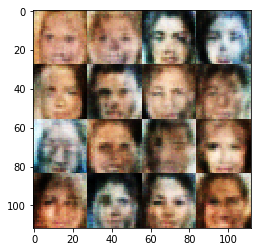

Epoch 1/1... Discriminator Loss: 0.7361... Generator Loss: 1.5545
Epoch 1/1... Discriminator Loss: 0.7974... Generator Loss: 1.4851
Epoch 1/1... Discriminator Loss: 0.9946... Generator Loss: 2.4110
Epoch 1/1... Discriminator Loss: 0.9490... Generator Loss: 1.0869
Epoch 1/1... Discriminator Loss: 0.9118... Generator Loss: 1.5182
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 1.5726
Epoch 1/1... Discriminator Loss: 0.9720... Generator Loss: 1.2326
Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 1.5448
Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 1.6220
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 2.0319


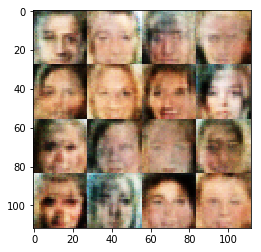

Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 2.0013
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 1.0796
Epoch 1/1... Discriminator Loss: 0.9410... Generator Loss: 1.3741
Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 1.1911
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 0.9644
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 1.9461
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 1.2645
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.5584
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 0.8832


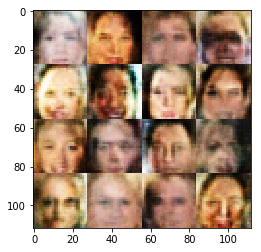

Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 1.1021
Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 1.5149
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 0.9359
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 1.0814
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 1.3513
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 1.0565
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 1.0976
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 1.2302


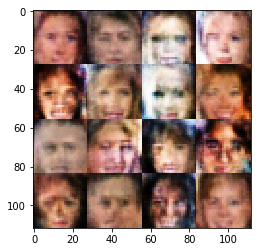

Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 1.4072
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 1.2900
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 1.1807
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.9757


KeyboardInterrupt: 

In [49]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.